<a href="https://colab.research.google.com/github/barnabasp/ML_Course/blob/main/bporfy_lab_10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Convolutional neural networks

In this assignment you'll use a photo-Z dataset acquired from the observations of the SDSS telescope located in New Mexico. The goal is to predict redshifts from multiband images of galaxies. As a warmup you'll work with the SVHN dataset.

**<font color='red'>[WARN]:</font> For this assignment you'll need significantly more computational power compared to previous assignments! If you don't have a CUDA-capable GPU with >4Gb VRAM and >8Gb RAM, then you're advised to work on Google Colab!**

In [11]:
#!unzip /content/drive/MyDrive/Colab\ Notebooks/10/archive.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initial setup above

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from extra_keras_datasets import svhn
import tensorflow as tf
import keras

In [5]:
#!pip install extra-keras-datasets

### 1. Load the Street View House Numbers (SVHN) dataset

-   Download the SVHN database and load the train and test datasets!
    There are multiple ways to do this. The easiest one is probably to install
    and use the `extra-keras-datasets` Python package. You need to use the
    standard/normal SVHN dataset only and NOT the one titled as `extra`!
    (Of course, if you have enough RAM and VRAM, you can work with that one
    too, if you want...)
-   Preprocess the downloaded data if needed to be able to use it for training
    and testing!
-   Normalize the pixel values into the interval of [0,1]!
-   How many and what classes do we have in the dataset? How many train and test
    examples do we have?
-   What are the dimensions of the images?
-   Show some images randomly from the dataset!
-   Make one-hot encoding for the labels!

Download and check the data

In [6]:
(X_train, y_train), (X_test, y_test) = svhn.load_data(type='normal')

INFO:root:Loading dataset = svhn


64290816/64275384 [==============================] - 5s 0us/step


In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [8]:
np.isnan(X_train).sum(),np.isnan(y_train).sum(),np.isnan(X_test).sum(),np.isnan(y_test).sum()

(0, 0, 0, 0)

Need to make the pixels between 0 and 1.

In [9]:
X_train.min(), X_train.max()

(0, 255)

In [10]:
# from https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm
from keras import backend as K
img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first': 
   x_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) 
   x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols) 
   input_shape = (1, img_rows, img_cols) 
else: 
   x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3) 
   x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3) 
   input_shape = (img_rows, img_cols, 3) 
   
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train /= 255 
x_test /= 255

In [11]:
#x_train = X_train.reshape(73257, 32*32*3)/255
#x_test = X_test.reshape(26032, 32*32*3)/255

Shapes of the sets in order: input train, output train, input test, output test

In [12]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

Text(0.5, 1.0, 'This is number 8')

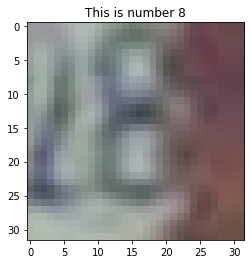

In [13]:
plt.imshow(x_train[19].reshape(32,32,3))
plt.title('This is number %i'%y_train[19])

Text(0.5, 1.0, 'This is number 8')

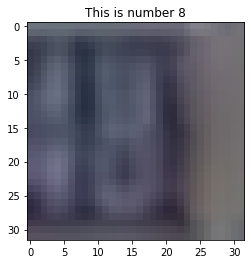

In [14]:
plt.imshow(x_train[727].reshape(32,32,3))
plt.title('This is number %i'%y_train[727])

In [15]:
print("Unique classes: ", len(np.unique(y_test)))

Unique classes:  10


In [16]:
np.unique(y_test-1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

One hot encoding, seems OK!

In [17]:
y_train_oh = tf.keras.utils.to_categorical(y_train-1, 10)
y_test_oh = tf.keras.utils.to_categorical(y_test-1, 10)
print(y_train_oh[:5], y_train[:5])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] [1 9 2 3 2]


### 2. Create a convolutional neural network for the SVHN dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling kernel size = (2,2)
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling pool size = (2,2) strides = (2,2)
          > flatten
          > dense, 10 neurons, softmax activation
    ```
    -   Use Adam optimizer with default parameters
    -   Use categorical crossentropy as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64
    -   Use the test data as validation data

-   Calculate the categorical cross-entropy loss and the accuracy!
    **<font color='green'>[HINT]:</font>** you should get at least $\approx$ 80-90%
    accuracy.
-   Plot the training and the validation loss and accuracy on the same plot!
    Do we experience overfitting?
-   Show the confusion matrix of the predictions!

Aided with understanding the exercise: https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm

In [18]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 

In [19]:
x_train.shape

(73257, 32, 32, 3)

In [20]:
model = tf.keras.Sequential()
model.add(Conv2D(16,
                 kernel_size=(3,3),
                 padding='valid',
                 activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','AUC'])

In [22]:
history = model.fit(x=x_train, y=y_train_oh,
                    batch_size=64, epochs=25,
                    validation_data=(x_test, y_test_oh))

Epoch 1/25
1145/1145 [==============================] - 25s 13ms/step - loss: 0.9209 - accuracy: 0.7096 - auc: 0.9494 - val_loss: 0.6195 - val_accuracy: 0.8294 - val_auc: 0.9738
Epoch 2/25
1145/1145 [==============================] - 14s 12ms/step - loss: 0.5020 - accuracy: 0.8555 - auc: 0.9825 - val_loss: 0.5095 - val_accuracy: 0.8580 - val_auc: 0.9815
Epoch 3/25
1145/1145 [==============================] - 13s 11ms/step - loss: 0.4409 - accuracy: 0.8729 - auc: 0.9858 - val_loss: 0.4944 - val_accuracy: 0.8576 - val_auc: 0.9828
Epoch 4/25
1145/1145 [==============================] - 14s 12ms/step - loss: 0.4050 - accuracy: 0.8822 - auc: 0.9877 - val_loss: 0.4515 - val_accuracy: 0.8728 - val_auc: 0.9854
Epoch 5/25
1145/1145 [==============================] - 14s 12ms/step - loss: 0.3822 - accuracy: 0.8894 - auc: 0.9888 - val_loss: 0.4516 - val_accuracy: 0.8706 - val_auc: 0.9847
Epoch 6/25
1145/1145 [==============================] - 14s 12ms/step - loss: 0.3637 - accuracy: 0.8940 - auc:

### 3. Load the Sload Digital Sky Survey (SDSS) Dataset

You can download the dataset from Kaggle via
[this link](https://www.kaggle.com/masterdesky/multiband-photoz-sdss-dr16).

-   Download the images from Kaggle (~10'000 images total) 
-   Preprocess the images similarly to the SVHN dataset if needed! (Normalize
    pixel values to [0,1], etc.)
-   What are the dimensions of the images?
-   Show 15 images randomly from the dataset!
-   Create a train-test-validation split using `train_test_split` from `sklearn`
    where the test size is $0.33$ and the validation size is $0.2$
    -   Set a random seed
    -   Print the number of images in each of these sets after you've created
        them

### 4. Create a convolutional neural network for the SDSS dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (1,1), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > global pooling
          > dense, 1 neuron, no activation
    ```

    -   Use Adam optimizer with default parameters
    -   Use mean squared error as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Use the created validation set as validation during the training
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64

-   Calculate and print out the final accuracy using the R2 score!

### 5. Evaluate performance

-   Plot the training and the validation loss on the same plot!
-   Show the predicted values vs the actual labels on a plot!
-   Where does the model make mistakes? Try to plot the images corresponding to
    some outlier values!

### 6. Train an other CNN

-   The previous architecture can be further improved.
-   Come up with an architecture that can achieve more than 80-85% accuracy on 
    the test set if the accuracy metric is the R2 score!
    -   You can use any tool for this task.
    -   Remember that there are different losses and optimizers, early stopping,
        regularization, etc. that can be useful for you. You can find more about 
        these eg. in the
        [tensorflow/keras documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).
    -   Don't forget that you can add more layers to the model and train for
        more epochs too... :)
-   Print out the summary of this model!
-   Plot the loss curves for this model too!